In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
!pip install tensorflow

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, Dense, Flatten, Concatenate, Input, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# 모델 학습을 위해 userId, movieId 인덱스 변환
ratings = pd.read_csv('/content/drive/MyDrive/BigData/Project/ratings.csv')

user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings['user_idx'] = user_encoder.fit_transform(ratings['userId'])
ratings['movie_idx'] = movie_encoder.fit_transform(ratings['movieId'])

ratings.set_index(['user_idx', 'movie_idx'], inplace=True)

# tmdb의 tmdb_id랑 ratings의 movieId 매핑을 위해 links.csv 병합
links = pd.read_csv('/content/drive/MyDrive/BigData/Project/links.csv')
ratings_with_tmdb = pd.merge(ratings.reset_index(), links[['movieId', 'tmdbId']], on='movieId', how='left')

ratings_with_tmdb.head(5)
ratings_with_tmdb.shape

(100836, 7)

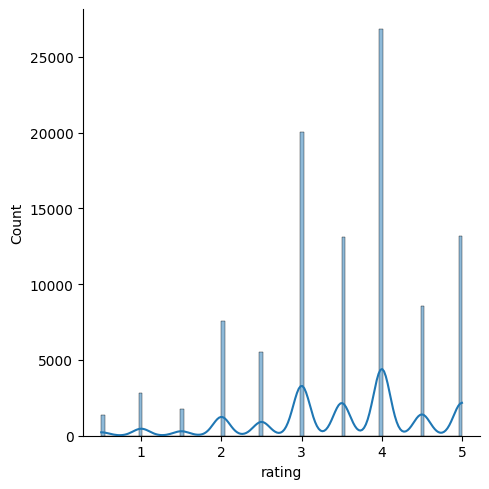

In [47]:
sns.displot(ratings_with_tmdb['rating'], kde=True)
plt.show()

In [48]:
# 훈련 데이터 준비
x_train = [ratings_with_tmdb['user_idx'], ratings_with_tmdb['movie_idx']]
y_train = ratings_with_tmdb['rating']

# numpy 배열로 변환
x_train = [np.array(x_train[0]), np.array(x_train[1])]
y_train = np.array(y_train)

# 훈련, 검증 세트 분할
x_train_combined = np.column_stack((x_train[0], x_train[1]))
x_train, x_val, y_train, y_val = train_test_split(
    x_train_combined, y_train, test_size=0.2, random_state=42)

print(f"훈련 데이터 크기: {x_train.shape}, 검증 데이터 크기: {x_val.shape}")

훈련 데이터 크기: (80668, 2), 검증 데이터 크기: (20168, 2)


In [49]:
# 모델 구축

embedding_dim = 50

user_input = Input(shape=(1,), name='user')
movie_input = Input(shape=(1,), name='movie')

user_embedding = Embedding(len(user_encoder.classes_), output_dim=embedding_dim)(user_input)
movie_embedding = Embedding(len(movie_encoder.classes_), output_dim=embedding_dim)(movie_input)

user_flattend = Flatten()(user_embedding)
movie_flattend = Flatten()(movie_embedding)

concat = Concatenate()([user_flattend, movie_flattend])

dense_1 = Dense(256)(concat)
dense_1 = LeakyReLU()(dense_1)
dropout_1 = Dropout(0.3)(dense_1)
dense_2 = Dense(128)(dropout_1)
dense_2 = LeakyReLU()(dense_2)

output = Dense(1)(dense_2)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model = Model(inputs=[user_input, movie_input], outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, 1, 50)     │     30,500 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, 1, 50)     │    486,200 │ movie[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 50)        │          0 │ embedding_16[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 50)        │          0 │ embedding_17[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 100)       │          0 │ flatten_16[0][0], │
│ (Concatenate)       │                   │            │ flatten_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │     25,856 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 256)       │          0 │ dense_18[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │     32,896 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 128)       │          0 │ dense_19[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1)         │        129 │ leaky_re_lu_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 575,581 (2.20 MB)

 Trainable params: 575,581 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# 모델 학습
history = model.fit(
    [x_train[:, 0], x_train[:, 1]], y_train,
    epochs=10, batch_size=64, validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 1.8040 - mae: 0.9687 - val_loss: 0.7981 - val_mae: 0.6827
Epoch 2/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.7349 - mae: 0.6612 - val_loss: 0.7760 - val_mae: 0.6689
Epoch 3/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.6886 - mae: 0.6366 - val_loss: 0.7621 - val_mae: 0.6691
Epoch 4/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.6539 - mae: 0.6171 - val_loss: 0.7664 - val_mae: 0.6682
Epoch 5/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.6247 - mae: 0.6032 - val_loss: 0.7604 - val_mae: 0.6701
Epoch 6/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.5961 - mae: 0.5885 - val_loss: 0.7687 - val_mae: 0.6721
Epoch 7/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.5766 - mae: 0.5777 - val_loss: 0.7699 - val_mae: 0.6731
Epoch 8/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.5598 - mae: 0.5662 - val_loss: 0.7853 - val_mae: 0.6716


In [51]:
# 모델 평가 및 예측
x_val_user = x_val[:, 0]
x_val_movie = x_val[:, 1]

test_loss, test_mae = model.evaluate([x_val_user, x_val_movie], y_val)
print(f"검증 데이터 손실: {test_loss}, MAE: {test_mae}")

predictions = model.predict([x_val_user, x_val_movie])

for i in range(5):
  print(f"예측된 평점: {predictions[i][0]}, 실제 평점: {y_val[i]}")

631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7678 - mae: 0.6728
검증 데이터 손실: 0.7604044675827026, MAE: 0.6700982451438904
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
예측된 평점: 3.303703784942627, 실제 평점: 4.5
예측된 평점: 3.374965190887451, 실제 평점: 3.0
예측된 평점: 2.5989506244659424, 실제 평점: 3.0
예측된 평점: 3.668975353240967, 실제 평점: 4.0
예측된 평점: 3.4605648517608643, 실제 평점: 4.0
